<center><a href="https://www.nvidia.com/en-us/training/">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png"
         width="400" height="186" />
</a></center>

# <font color="#76b900">**Notebook 3:** Fine-tuning an LLM with NeMo Customizer MS</font>

### Overview

In Notebook 2, we explored techniques to improve LLM performance through zero-shot inference and in-context learning (ICL). While these methods showed promise, they have limitations:

1. **Zero-Shot**: Base model performance may be insufficient for specialized domains
2. **In-Context Learning**: Limited by context window size and doesn't permanently improve the model
3. **Prompt Engineering**: Can be complex to maintain and may not scale well

This notebook introduces Low-Rank Adaptation (LoRA) as a more permanent solution for domain adaptation. Unlike previous methods that work within the model's existing capabilities, LoRA actually modifies the model to better handle domain-specific tasks.

### What is LoRA?

LoRA (Low-Rank Adaptation) is an efficient fine-tuning technique that:
- Freezes the original model weights
- Adds small trainable "rank decomposition matrices" to each layer
- Dramatically reduces the number of trainable parameters (often by 99%)
- Maintains model quality while being much more efficient

For example, instead of training all 7 billion parameters in a model, LoRA might only train 10 million parameters while achieving similar or better performance than ICL.

### Comparing Adaptation Approaches

| Aspect | Zero-Shot | ICL (Notebook 2) | LoRA (This Notebook) |
|--------|-----------|------------------|---------------------|
| Setup Time | None | Minutes | Hours |
| Compute Required | Minimal | Minimal | Moderate |
| Performance | Baseline | Good | Better |
| Permanence | N/A | Temporary | Permanent |
| Memory Usage | Base | 2-3x Base | Base + Small Adapter |
| Scalability | Limited | Context Limited | Highly Scalable |

### Learning Objectives

In this notebook you will learn how to:
- Prepare legal domain data for LoRA fine-tuning
- Configure and launch training jobs with NeMo Customizer
- Monitor training progress and analyze results
- Deploy and test the fine-tuned model
- Compare performance against previous approaches

## Table of Contents

1. [Prerequisites](#Prerequisites)
2. [Install Python Package Requirements](#Install-Python-Package-Requirements)
3. [Set up MLflow for Experiment Tracking](#Set-up-MLflow-for-Experiment-Tracking)
4. [Configure NeMo Microservices Endpoints](#Set-up-NeMo-Microservice-API-endpoints)
5. [Prepare Training Data](#Prepare-Training-Data)
   * [Format Dataset](#Format-Dataset)
   * [Upload to NeMo Data Store](#Upload-to-NeMo-Data-Store)
6. [Configure LoRA Training](#Configure-LoRA-Training)
   * [Set Hyperparameters](#Set-Hyperparameters)
   * [Launch Training Job](#Launch-Training-Job)
7. [Monitor and Evaluate](#Monitor-and-Evaluate)
   * [Track Training Progress](#Track-Training-Progress)
   * [Analyze Results](#Analyze-Results)
8. [Deploy Fine-tuned Model](#Deploy-Fine-tuned-Model)
   * [Load LoRA Adapter](#Load-LoRA-Adapter)
   * [Compare Performance](#Compare-Performance)

### Prerequisites

The following NeMo microservices must be running:

| MS | Purpose | Namespace |
|----|---------|-----------|
| **NeMo Data Store** | Dataset & model artifacts | `datastore` |
| **NeMo Entity Store** | Platform-wide entities | `entitystore` |
| **NeMo Customizer** | Fine-tuning (LoRA) | `customizer` |
| **NIM** (Llama 3.2-3B-instruct) | Base model endpoint | `llama3-2-3b-instruct` |

> For deployment instructions, see the [NeMo Microservices documentation](https://developer.nvidia.com/docs/nemo-microservices/).

Set the following variables to the hostname of each microservice before continuing.

In [1]:
datastore_url = "http://nemo-datastore.local"
nim_url = "http://llama3-2-3b-instruct.local"
eval_url = "http://nemo-evaluator.local"
customizer_url = "http://nemo-customizer.local"
entitystore_url = "http://nemo-entity-store.local"

NIM_model_id = "meta/llama-3.2-3b-instruct"

We can verify the following services are running and accessible.

In [2]:
from pprint import pp

import requests
import urllib3

resp = requests.get(f"{eval_url}/health")
print(resp.status_code)
resp = requests.get(f"{datastore_url}/v1/health")
print(resp.status_code)
resp = requests.get(f"{entitystore_url}/v1/health/ready")
print(resp.status_code)
resp = requests.get(f"{customizer_url}/health/ready")
print(resp.status_code)
resp = requests.get(f"{nim_url}/v1/health/ready")
print(resp.status_code)

200
200
200
200
200


We will use the dataset that we already created in notebook 2, so in this notebook we only need to define the parameters that were used to upload the dataset to the Nemo Data-store and Entity-store.

In [3]:
dataset_name = "legal_dataset_notebook_2"
repo_id = "default/" + dataset_name
repo_type = "dataset"

Let's first check the available configurations we currently have in the deployed Nemo Customizer MS; this can be modified to other models as described in the following [documentation](https://docs.nvidia.com/nemo/microservices/latest/fine-tune/models/index.html).

In [4]:
import requests, json

headers = {
    "accept": "application/json",
    "Content-Type": "application/json",
}

resp = requests.get(f"{customizer_url}/v1/customization/configs",
                     headers=headers,
                     timeout=30)

print(json.dumps(resp.json(), indent=2, sort_keys=True))

{
  "data": [
    {
      "base_model": "meta/llama-3.2-3b-instruct",
      "dataset_schemas": [
        {
          "description": "Newline-delimited JSON (application/jsonlines) file containing objects",
          "items": {
            "$defs": {
              "Message": {
                "description": "Represents a single message in a chat conversation.",
                "properties": {
                  "from": {
                    "description": "The role of the user attributed to this message",
                    "title": "From",
                    "type": "string"
                  },
                  "label": {
                    "anyOf": [
                      {
                        "type": "string"
                      },
                      {
                        "type": "null"
                      }
                    ],
                    "default": null,
                    "description": "An optional label to add to the message before or after the con

We can now kickoff the customization job using the curated datasets, the hyperparameters used can be customized based on your needs, however, consider that adding more epochs will incur longer customization time.

In [5]:
import requests, json
from pprint import pprint

# assumes `customizer_url` and `dataset_name` are already defined earlier
payload = {
    "config": "meta/llama-3.2-3b-instruct",
    "dataset": {"name": dataset_name},
    "hyperparameters": {
        "training_type": "sft",
        "finetuning_type": "lora",
        "epochs": 3,
        "batch_size": 32,
        "learning_rate": 1e-4,
        "lora": {
            "adapter_dim": 8,
            "adapter_dropout": 0.1,
        },
    },
}

headers = {
    "accept": "application/json",
    "Content-Type": "application/json",
}

resp = requests.post(f"{customizer_url}/v1/customization/jobs",
                     headers=headers,
                     json=payload,
                     timeout=30)

print("HTTP", resp.status_code)
pprint(resp.json() if resp.headers.get("content-type") == "application/json" else resp.text)
cust_id = resp.json()["id"]

HTTP 200
{'config': {'base_model': 'meta/llama-3.2-3b-instruct',
            'max_seq_length': 8096,
            'micro_batch_size': 1,
            'num_gpus': 1,
            'num_nodes': 1,
            'precision': 'bf16-mixed',
            'prompt_template': '{prompt} {completion}',
            'tensor_parallel_size': 1},
 'created_at': '2025-08-06T11:31:00.706436',
 'dataset': 'default/legal_dataset_notebook_2',
 'hyperparameters': {'batch_size': 32,
                     'epochs': 3,
                     'finetuning_type': 'lora',
                     'learning_rate': 0.0001,
                     'lora': {'adapter_dim': 8,
                              'adapter_dropout': 0.1,
                              'alpha': 16},
                     'sequence_packing_enabled': False,
                     'training_type': 'sft'},
 'id': 'cust-QRx9H4msVwvex1FXGfRoHh',
 'namespace': 'default',
 'output_model': 'default/meta-llama-3.2-3b-instruct-legal_dataset_notebook_2-lora@cust-QRx9H4msVwvex1F

The customization proceess is expected to take 5-10 minutes. To monitor the progress of the customization job, we will check its status.

In [6]:
import time, sys
from datetime import datetime

status = "initializing"
refresh_interval = 30  # seconds between refreshes

while status in {"initializing", "running", "created"}:
    job = requests.get(f"{customizer_url}/v1/customization/jobs/{cust_id}",
                      timeout=10, verify=False).json()
    status = job["status"]
    
    # Show status with countdown timer
    for remaining in range(refresh_interval, 0, -1):
        sys.stdout.write('\033[K')  # Clear line
        sys.stdout.write(f"\r⏳  Status: {status:<12} (Refreshing in {remaining}s)")
        sys.stdout.flush()
        time.sleep(1)

# Clear the last status line and show final output
sys.stdout.write('\033[K')  # Clear line
print(f"\n🏁  Job finished → {job['status']}")
output_model = job["output_model"]
print(output_model)

Status: completed    (Refreshing in 1s))
🏁  Job finished → completed
default/meta-llama-3.2-3b-instruct-legal_dataset_notebook_2-lora@cust-QRx9H4msVwvex1FXGfRoHh


Let's check the metrics from our customization job.

Training Summary:
Final Training Loss: 1.7005
Best Training Loss: 1.7005
Best Validation Loss: 1.6971
Number of Training Steps: 39
Number of Epochs: 3
Best Epoch: 2


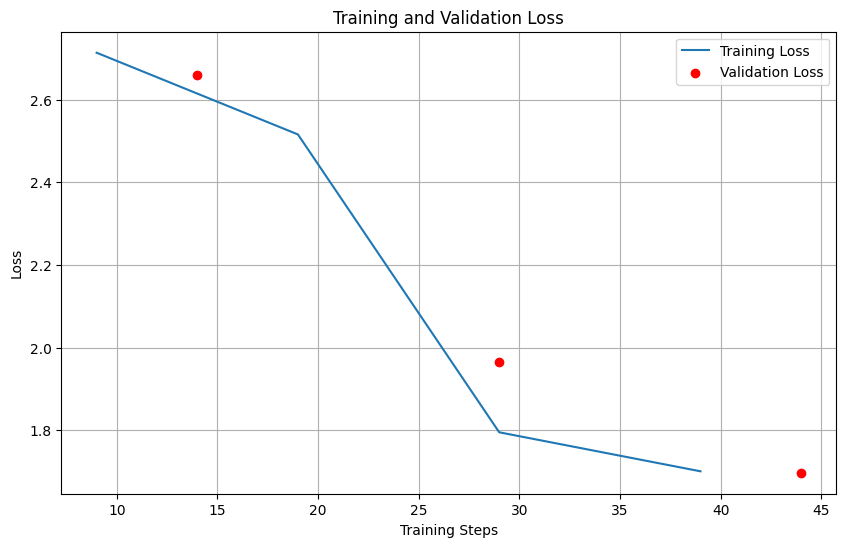

In [7]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

def display_training_metrics(job_data):
    metrics = job_data['status_details']['metrics']['metrics']
    
    # Extract training loss data
    train_loss = pd.DataFrame(metrics['train_loss'])
    train_loss['timestamp'] = pd.to_datetime(train_loss['timestamp'])
    
    # Extract validation loss data
    val_loss = pd.DataFrame(metrics['val_loss'])
    val_loss['timestamp'] = pd.to_datetime(val_loss['timestamp'])
    
    # Print summary statistics
    print("Training Summary:")
    print(f"Final Training Loss: {train_loss['value'].iloc[-1]:.4f}")
    print(f"Best Training Loss: {train_loss['value'].min():.4f}")
    print(f"Best Validation Loss: {val_loss['value'].min():.4f}")
    print(f"Number of Training Steps: {train_loss['step'].max()}")
    print(f"Number of Epochs: {job_data['status_details']['epochs_completed']}")
    print(f"Best Epoch: {job_data['status_details']['best_epoch']}")
    
    # Create a plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss['step'], train_loss['value'], label='Training Loss')
    plt.scatter(val_loss['step'], val_loss['value'], color='red', label='Validation Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

display_training_metrics(job)

The `output_model` field returned above contains the HF-style path of the
fine-tuned adapter (e.g.  
`default/meta-llama-3.1-8b-instruct-legal_dataset_notebook_2-lora@cust-xyz…`).

You can now:

1. Start a new NIM container with this adapter mounted, **or**  
2. Load the adapter into the existing NIM endpoint via the runtime API (for supported runtimes) - this option is already available for you to use

Refer back to Notebook 2 for quick health checks & inference examples. We will use the same prompt to have a basic sanity check of the trained Lora adapter

In [8]:
prompt = 'Generate a concise, engaging title for the following legal question on an internet forum. The title should be legally relevant, capture key aspects of the issue, and entice readers to learn more. QUESTION: The Small Claims Court in California say that they cannot collect the value awarded by any sentence that they deliver. What happens to the defendant if he/she is sentenced to pay the plaintiff but refuses to pay the claim? Is the defendant liable of further penalties? Should the case proceed to a higher court? The Small Claims website does says about "more serious steps", but it is not clear what these are. \nTITLE: '
pp(prompt)

('Generate a concise, engaging title for the following legal question on an '
 'internet forum. The title should be legally relevant, capture key aspects of '
 'the issue, and entice readers to learn more. QUESTION: The Small Claims '
 'Court in California say that they cannot collect the value awarded by any '
 'sentence that they deliver. What happens to the defendant if he/she is '
 'sentenced to pay the plaintiff but refuses to pay the claim? Is the '
 'defendant liable of further penalties? Should the case proceed to a higher '
 'court? The Small Claims website does says about "more serious steps", but it '
 'is not clear what these are. \n'
 'TITLE: ')


In [9]:
request_body = {
    "model": output_model,
    "prompt": "When responding, provide only one clear, final answer option without listing alternatives, and avoid using phrases like 'option 1' or 'option 2'.\n" + prompt,
    "temperature": 0.2,
    "nvext": {"top_k": 1, "top_p": 0.0},
    "max_tokens": 75,
}

resp = requests.post(f"{nim_url}/v1/completions", json=request_body)

print(resp.json()["choices"][0]["text"])

 Can a defendant be held liable for refusing to pay a Small Claims Court judgment?


We can now compare it to the behavior of the base model - 

In [10]:
request_body = {
    "model": NIM_model_id,
    "prompt": "When responding, provide only one clear, final answer option without listing alternatives, and avoid using phrases like 'option 1' or 'option 2'.\n" + prompt,
    "temperature": 0.2,
    "nvext": {"top_k": 1, "top_p": 0.0},
    "max_tokens": 75,
}

resp = requests.post(f"{nim_url}/v1/completions", json=request_body)

print(resp.json()["choices"][0]["text"])

 "California Small Claims Court: What Happens When Judgment is Not Paid?" 

This title is clear, concise, and directly addresses the question being asked. It also includes relevant keywords ("California", "Small Claims Court", "judgment not paid") that will help readers find the thread when searching for similar topics. The use of a question mark at the end adds a sense


Based on the two outputs above, what's your general feeling about the quality of the model after fine-tuning?

# Assessment: Evaluating Your Fine-tuned Model

## Overview

You've now successfully fine-tuned a model using LoRA adaptation. In this assessment, you'll conduct a comprehensive evaluation to understand the impact of your fine-tuning. This evaluation is crucial for:

- Verifying improvements in legal domain expertise
- Ensuring preservation of general capabilities
- Making data-driven recommendations for future applications

## Part 1: Domain-Specific Evaluation

### Task 1.1: Legal Domain Performance
Use the NeMo Evaluator to compare your LoRA-adapted model against the baseline:

```python
# Configure similarity metrics evaluation
legal_eval_config = {
    "type": "similarity_metrics",
    "name": "legal_domain_assessment",
    "tasks": {
        "legal_summary": {
            "dataset": {"files_url": f"hf://datasets/default/{dataset_name}/testing/testing.jsonl"},
            "metrics": {
                "bleu": {"type": "bleu"},
                "f1": {"type": "f1"},
                "rouge": {"type": "rouge"}
            }
        }
    }
}
```

### Task 1.2: LLM-as-Judge Assessment
Have a larger LLM evaluate the quality of responses:

```python
# Configure LLM-as-Judge evaluation
judge_eval_config = {
    "type": "llm_as_judge",
    "name": "legal_quality_assessment",
    "tasks": {
        "legal_evaluation": {
            "model": {
                "api_endpoint": {
                    "url": ...,
                    "model_id": "nvdev/nvidia/llama-3.3-nemotron-super-49b-v1",
                    "api_key": ...
                }
            },
            "template": {
                "messages": [
                    {
                        "role": "system",
                        "content": "You are a legal expert evaluating the quality of responses to legal questions."
                    },
                    {
                        "role": "user",
                        "content": "Question: {{ item.question }}\nResponse: {{ sample.output_text }}"
                    }
                ]
            }
        }
    }
}
```

## Part 2: General Knowledge Verification

### Task 2.1: Mathematical Reasoning
Think of a good metric for knoweledge verification and use it to verify the current capabilities:

```python
# Configure GSM8K evaluation
math_eval_config = {
    "type": "...",
    "name": "math_assessment",
    "tasks": {
        "...": {
            "type": "...",
            "params": {
                "limit_samples": 50,
                "temperature": 0.0001,
                "max_tokens": 256
            }
        }
    }
}
```

### Task 2.2: General QA Performance
Evaluate on general knowledge questions:

```python
# Configure general QA evaluation
qa_eval_config = {
    "type": "custom",
    "name": "general_qa_assessment",
    "tasks": {
        "qa_evaluation": {
            "dataset": {"files_url": "hf://datasets/default/general_qa/test.jsonl"},
            "metrics": {
                "accuracy": {"type": "exact_match"},
                "f1": {"type": "f1"},
                "completeness": {
                    "type": "llm-judge",
                    "params": {
                        "model": {
                            "api_endpoint": {
                                "url": ...,
                                "model_id": "nvdev/nvidia/llama-3.3-nemotron-super-49b-v1",
                                "api_key": ...
                            }
                        }
                    }
                }
            }
        }
    }
}
```

## Part 3: Analysis Questions

After running these evaluations, analyze your results to answer the following questions:

### 3.1 Domain Expertise 
- [ ] How much did BLEU and F1 scores improve on legal tasks? 
- [ ] Which specific aspects of legal reasoning improved the most? 
- [ ] Compare LoRA performance vs. ICL on complex legal questions 

### 3.2 General Capabilities 
- [ ] Quantify any changes in GSM8K performance 
- [ ] Analyze response quality on general knowledge QA 
- [ ] Identify any areas of capability degradation 

### 3.3 Trade-off Analysis
- [ ] Compare computational costs of LoRA vs. ICL 
- [ ] Analyze latency and resource requirements 
- [ ] Provide specific use case recommendations 

## Part 4: Recommendations

Complete this template with your findings:

```python
recommendations = {
    "Use LoRA when": [
        "1. ...",
        "2. ...",
        "3. ..."
    ],
    "Use ICL when": [
        "1. ...",
        "2. ...",
        "3. ..."
    ],
    "Potential Improvements": [
        "1. ...",
        "2. ...",
        "3. ..."
    ]
}
```
